# Bien, ahora que tenemos corregidas las tablas, lo que sigue es establecer las relaciones entre estas.

## Para guiarme voy a utilizar el diagrama de relaciones que quedo guardado en el archivo de PowerBi, para luego establecer las claves foraneas y generar las vistas correspondientes.


**1) Relación entre customers (clave primaria: customerID) y orders(clave primaria: customerID), clave foranea customerID para ambos**
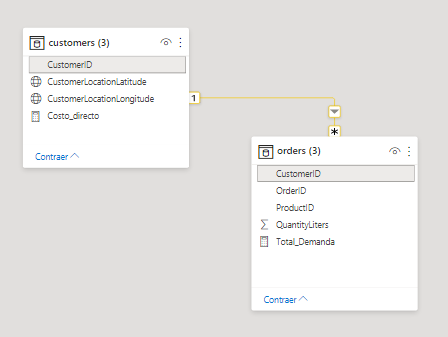

**2) La ralacion se da entre las tablas plants y variable_costs. Nota: la tabla de capacidades de plantas es un derivado de la tabla plants**
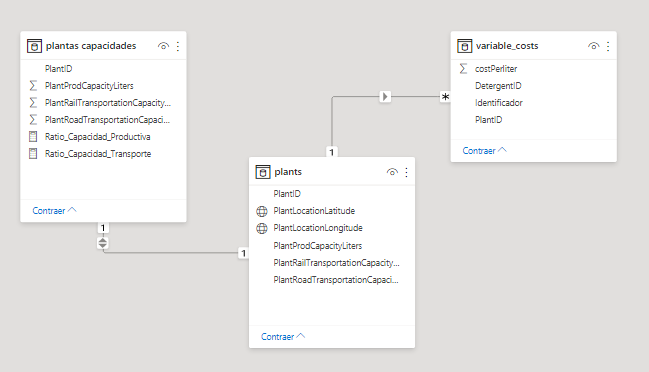

**3) La relacion se establece entre las tablas routes_availables, routes_segment y routes_endtoend. Nota: la tabla adicional de routes_segment se eleboró porque no se podia hacer una doble llamada sobre una misma tabla**
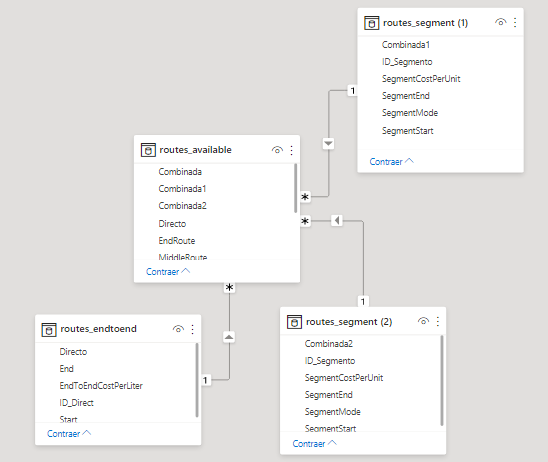

In [4]:
# Conectar con base de datos
from raaraya1 import SQL
import pandas as pd
import psycopg2

usuario = SQL('curso_postgresql', 'Tester', '123456')


In [ ]:
# voy a partir estableciendo las claves primarias del ejercicio 1
#comando_base = 'alter table {} add primary key ({})'.format(tabla, columna)


In [2]:
# tabla customers
## miremos la tabla
comando = 'select * from customers'
columnas, df = usuario.mostrar_tabla(comando, 'customers')
print(columnas)
df


[('(customerid,"character varying")',), ('(customerlocationlatitude,"character varying")',), ('(customerlocationlongitude,"character varying")',)]


,0,1,2
0,Customer001,-69.7415041,5.7217254
1,Customer002,-17.74631895,7.71807615
2,Customer003,67.41158818,79.0660602
3,Customer004,-71.91233417,-25.39319369
4,Customer005,68.44101913,-62.49004925
5,Customer006,-58.8784902,-22.07052049
6,Customer007,27.39095208,-49.38065519


## **Antes de nombra una columna como clave primaria, debiesemos cerciorarnos de que no existan valores repetidos, es decir, asegurar la columna que vamos a seleccionar como clave primaria cuente con la condicion de identificar registros unicos.**


In [4]:
# Una forma rapida de como se me ocurre verificar esto es utilizando conjuntos
## nota: los conjuntos trabajan sin valores duplicados, de ahi su ventaja
## ejemplo
lista = [1, 1, 2]
conjunto = set(lista)
print(conjunto) # esto imprime {1, 2}

## la gracias es verificar con la cantidad de elementos que se generan
print(len(lista))
print(len(conjunto))

### como difieren en sus valores, luego no podria decir que la lista funciona como clave primeria

{1, 2}
3
2


In [9]:
# ahora aplicandolo a la tabla, verifiquemos si la primera columna (customerid) asegura unicidad
columna1 = list(df[0][:])
print(columna1)

# primera condicion: la columna 1 no posee valore duplicados
conjunto1 = set(columna1)
if len(columna1) == len(conjunto1):
    print('primera condicion: OK')
else:
    print('primera condicion: Error')

# segunda condicion: que identifique valores unicos para el resto de las columnas
## Ojo que esta condicion hay que mirarla con los datos que se estan trabajando, ya que, para este caso
## yo me podria encontrar en la situacion de que dos clientes distintos vivan en una misma locacion


['Customer001', 'Customer002', 'Customer003', 'Customer004', 'Customer005', 'Customer006', 'Customer007']
primera condicion: OK


In [10]:
# Establecemos customerid como clave primaria
comando = 'alter table customers add primary key (customerid)'
usuario.ejecutar(comando)


InvalidTableDefinition: no se permiten múltiples llaves primarias para la tabla «customers»


### Revisando desde el administrador, efectivamente ya tenia marcada la columna customerid como primary key (**quiza se deba a que esta no la importe desde aqui**)

In [11]:
# para aplicar una foreign key

#comando_base = '''alter table {} 
#               add constraint FK{} 
#               foreign key({}) 
#               references {} ({}).'''.format(tabla1, columna1 + '_' + columna2 ,columna1, tabla2, columna2)

# miremos la tabla orders
comando = 'select * from orders'
columnas, df = usuario.mostrar_tabla(comando, 'orders')
print(columnas)
df


[('(orderid,"character varying")',), ('(productid,"character varying")',), ('(customerid,"character varying")',), ('(quantityliters,integer)',)]


,0,1,2,3
0,Order001,Det004,Customer001,9
1,Order002,Det002,Customer007,19
2,Order003,Det001,Customer003,19
3,Order004,Det002,Customer005,16
4,Order005,Det005,Customer002,2
5,Order006,Det003,Customer007,5
6,Order007,Det003,Customer002,1
7,Order008,Det003,Customer005,16
8,Order009,Det005,Customer007,9
9,Order0010,Det001,Customer002,13


In [16]:
# Podemos notar que la relacion entre ambas tablas se generan con la columna customerid.
## ahora generemos esta relacion, desde customers a order

tabla1 = 'customers'
columna1 = 'customerid'
tabla2 = 'orders'
columna2 = 'customerid'
comando = '''alter table {} 
             add constraint FK{} 
             foreign key({}) 
             references {} ({})'''.format(tabla1, columna1 + '_' + columna2 ,columna1, tabla2, columna2)

usuario.ejecutar(comando)

InvalidForeignKey: no hay restricción unique que coincida con las columnas dadas en la tabla referida «orders»


In [17]:
# este error nos esta pidiendo que en la tabla orders exista una restriccion de unicidad.
## probemos hacer la relacion a la inversa (ya que en la tabla customers si aseguramos la unicidad)
tabla2 = 'customers'
columna2 = 'customerid'
tabla1 = 'orders'
columna1 = 'customerid'
comando = '''alter table {} 
             add constraint FK{} 
             foreign key({}) 
             references {} ({})'''.format(tabla1, columna1 + '_' + columna2 ,columna1, tabla2, columna2)

usuario.ejecutar(comando)

### Ahora podemos ver que no se generó el problema.
**Restricciones generadas en la tabla customers**
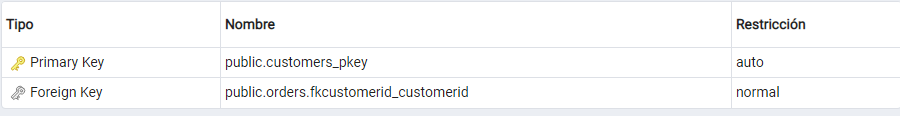

**Restricciones generadas en la tabla orders**
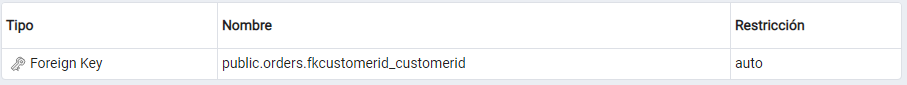

In [22]:
# Ahora (a modo de prueba) vamos a genera una vista de la informacion relacionada de ambas tablas
comando = 'select * from customers as c, orders as o where c.customerid = o.customerid'
df = usuario.mostrar_tabla(comando)

# para crear la vista
comando_vista = '''create view view_customers_orders 
                as {}'''.format(comando)
usuario.ejecutar(comando_vista)

DuplicateColumn: la columna «customerid» fue especificada más de una vez


In [26]:
# Interesante, al parecer no se puede crear una vista con una coluna duplicada. Arreglemos eso.
comando = '''select c.customerid, c.customerlocationlatitude, c.customerlocationlongitude, 
                    o.orderid, o.productid, o.quantityliters  
             from customers as c
             left join orders o
             on c.customerid = o.customerid'''

#df = usuario.mostrar_tabla(comando)

comando_vista = '''create view view_customers_orders 
                as {}'''.format(comando)
usuario.ejecutar(comando_vista)

### Podemos corroborara que se guardo la vista en la base de datos
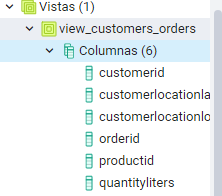

In [28]:
# Tambien la podemos llamar para ver su contenido
comando = 'select * from view_customers_orders'
df = usuario.mostrar_tabla(comando)
df


,0,1,2,3,4,5
0,Customer001,-69.7415041,5.7217254,Order001,Det004,9.0
1,Customer007,27.39095208,-49.38065519,Order002,Det002,19.0
2,Customer003,67.41158818,79.0660602,Order003,Det001,19.0
3,Customer005,68.44101913,-62.49004925,Order004,Det002,16.0
4,Customer002,-17.74631895,7.71807615,Order005,Det005,2.0
5,Customer007,27.39095208,-49.38065519,Order006,Det003,5.0
6,Customer002,-17.74631895,7.71807615,Order007,Det003,1.0
7,Customer005,68.44101913,-62.49004925,Order008,Det003,16.0
8,Customer007,27.39095208,-49.38065519,Order009,Det005,9.0
9,Customer002,-17.74631895,7.71807615,Order0010,Det001,13.0


## En el PowerBI habia conseguido hacer la siguiente visualizacion.
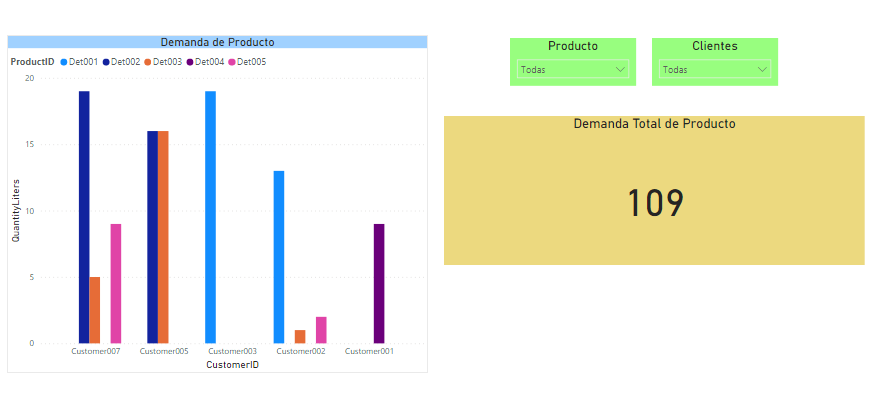

### Esta misma la podriamos generar solo a base a la tabla orders.


La siguinte sintaxis la podriamos calcular con postgreSQL.
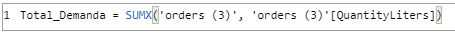

In [30]:
# aplicando operadores de postgre

# tarjeta
comando = '''select sum(quantityliters) from orders'''
df = usuario.mostrar_tabla(comando)
df


,0
0,109


In [33]:
# demanda por podructo y cliente
comando = '''select * from orders'''
df = usuario.mostrar_tabla(comando)
df


,0,1,2,3
0,Order001,Det004,Customer001,9
1,Order002,Det002,Customer007,19
2,Order003,Det001,Customer003,19
3,Order004,Det002,Customer005,16
4,Order005,Det005,Customer002,2
5,Order006,Det003,Customer007,5
6,Order007,Det003,Customer002,1
7,Order008,Det003,Customer005,16
8,Order009,Det005,Customer007,9
9,Order0010,Det001,Customer002,13


In [6]:
# me voy a ayudar para los graficos con la biblioteca de matplotlib

#%matplotlib.pyplot
import matplotlib.pyplot as plt


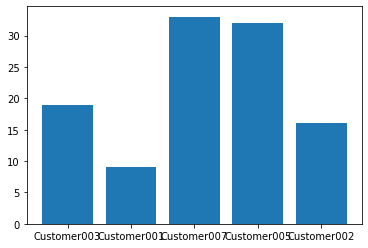

In [9]:
# grafico de barras (demanda por cliente)
comando = '''select customerid, sum(quantityliters) from orders group by customerid'''
df = usuario.mostrar_tabla(comando)

cliente = list(df[0][:])
demanda = list(df[1][:])

fig, ax = plt.subplots()
ax.bar(cliente, demanda)
plt.show()


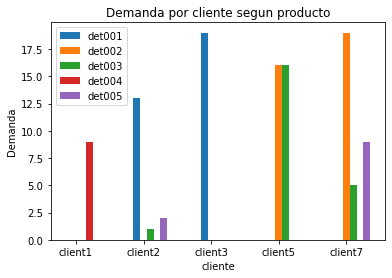

In [37]:
# grafico de barra (demanda por cliente por producto)
import numpy as np
comando = '''select * from orders'''
df = usuario.mostrar_tabla(comando)

# hay que hacer la segmentacion por productos (son 5 productos y 5 clientes)
det001 = np.zeros(5) 
det002 = np.zeros(5) 
det003 = np.zeros(5) 
det004 = np.zeros(5) 
det005 = np.zeros(5) 

for fila in range(len(df)):
    # detergente det001
    if df[1][fila] == 'Det001' and df[2][fila] == 'Customer001':    
        det001[0] = df[3][fila]
    elif df[1][fila] == 'Det001' and df[2][fila] == 'Customer002':
        det001[1] = df[3][fila]
    elif df[1][fila] == 'Det001' and df[2][fila] == 'Customer003':
        det001[2] = df[3][fila]        
    elif df[1][fila] == 'Det001' and df[2][fila] == 'Customer005':
        det001[3] = df[3][fila]        
    elif df[1][fila] == 'Det001' and df[2][fila] == 'Customer007':
        det001[4] = df[3][fila]
    
    # detergente det002
    elif df[1][fila] == 'Det002' and df[2][fila] == 'Customer001':
        det002[0] = df[3][fila]
    elif df[1][fila] == 'Det002' and df[2][fila] == 'Customer002':
        det002[1] = df[3][fila]
    elif df[1][fila] == 'Det002' and df[2][fila] == 'Customer003':
        det002[2] = df[3][fila]
    elif df[1][fila] == 'Det002' and df[2][fila] == 'Customer005':
        det002[3] = df[3][fila]
    elif df[1][fila] == 'Det002' and df[2][fila] == 'Customer007':
        det002[4] = df[3][fila]

    # detergente det003
    elif df[1][fila] == 'Det003' and df[2][fila] == 'Customer001':
        det003[0] = df[3][fila]
    elif df[1][fila] == 'Det003' and df[2][fila] == 'Customer002':
        det003[1] = df[3][fila]
    elif df[1][fila] == 'Det003' and df[2][fila] == 'Customer003':
        det003[2] = df[3][fila]
    elif df[1][fila] == 'Det003' and df[2][fila] == 'Customer005':
        det003[3] = df[3][fila]
    elif df[1][fila] == 'Det003' and df[2][fila] == 'Customer007':
        det003[4] = df[3][fila]

    # detergente det004       
    elif df[1][fila] == 'Det004' and df[2][fila] == 'Customer001':
        det004[0] = df[3][fila]
    elif df[1][fila] == 'Det004' and df[2][fila] == 'Customer002':
        det004[1] = df[3][fila]    
    elif df[1][fila] == 'Det004' and df[2][fila] == 'Customer003':
        det004[2] = df[3][fila]
    elif df[1][fila] == 'Det004' and df[2][fila] == 'Customer005':
        det004[3] = df[3][fila]
    elif df[1][fila] == 'Det004' and df[2][fila] == 'Customer007':
        det004[4] = df[3][fila]
        
    # detergente det005
    elif df[1][fila] == 'Det005' and df[2][fila] == 'Customer001':
        det005[0] = df[3][fila]
    elif df[1][fila] == 'Det005' and df[2][fila] == 'Customer002':
        det005[1] = df[3][fila]
    elif df[1][fila] == 'Det005' and df[2][fila] == 'Customer003':
        det005[2] = df[3][fila]
    elif df[1][fila] == 'Det005' and df[2][fila] == 'Customer005':
        det005[3] = df[3][fila]
    elif df[1][fila] == 'Det005' and df[2][fila] == 'Customer007':
        det005[4] = df[3][fila]

numero_de_grupos = len(det001)
indice_barras = np.arange(numero_de_grupos)
ancho_barras = 0.1
        
plt.bar(indice_barras, det001, width=ancho_barras, label='det001')
plt.bar(indice_barras + ancho_barras, det002, width=ancho_barras, label='det002')
plt.bar(indice_barras + 2*ancho_barras, det003, width=ancho_barras, label='det003')
plt.bar(indice_barras + 3*ancho_barras, det004, width=ancho_barras, label='det004')
plt.bar(indice_barras + 4*ancho_barras, det005, width=ancho_barras, label='det005')

plt.legend(loc='best')

plt.xticks(indice_barras + ancho_barras, ('client1', 'client2', 'client3', 'client5','client7'))
 
plt.ylabel('Demanda')
plt.xlabel('cliente')
plt.title('Demanda por cliente segun producto')
 
plt.show()


## Ahora continuemos con el segundo ejercicio (**entre las tablas plants y variable_costs**)


In [1]:
# conectemos
from raaraya1 import SQL
import pandas as pd
import psycopg2

usuario = SQL('curso_postgresql', 'Tester', '123456')


In [2]:
# revisemos la tabla 'plants'
comando = 'select * from plants'
columnas, df = usuario.mostrar_tabla(comando, 'plants')
print(columnas)
df



[('(plantid,"character varying")',), ('(plantlocationlatitude,"character varying")',), ('(plantlocationlongitude,"character varying")',), ('(plantprodcapacityliters,integer)',), ('(plantrailtransportationcapacityliters,integer)',), ('(plantroadtransportationcapacityliters,integer)',)]


,0,1,2,3,4,5
0,Plant001,67.95458019,30.95143418,760,324,362
1,Plant002,18.38170216,-23.86330645,906,76,201
2,Plant003,61.77910668,-29.66737339,691,382,345
3,Plant004,78.66031164,81.44016527,165,294,445
4,Plant005,53.05397278,-95.24078678,1000,292,499


In [4]:
# aseguremonos que la primera columna (plantid) pueda funcionar como primary key
## 1) Que no existan valores repetidos en su columna
columna1 = list(df[0][:])
conjunto1 = set(columna1)
if len(columna1) == len(conjunto1):
    print('ok')
else:
    print('revisar por valores duplicados')


ok


In [5]:
## 2) aseguremos que esta columna condicione registros unnicos 
### Para este caso en concreto no debiesen presentarse una misma locacion con dos ID

# revisemos esto de una similar a la anterior
columna2 = list(df[1][:])
columna3 = list(df[2][:])
lista_coordenadas = [columna2[i] + '_' + columna3[i] for i in range(len(columna2))]
conjunto_coordenadas = set(lista_coordenadas)
if len(lista_coordenadas) == len(conjunto_coordenadas):
    print('ok')
else:
    print('revisar por valores duplicados')



ok


In [6]:
# Como ambas condiciones fueron cumplidas, cooresponde asignar como primary key a la columna1
comando = 'alter table plants add primary key (plantid)'
usuario.ejecutar(comando)


### Repitamos el mismo proceso para la tabla 'variable_costs'


In [8]:
# mirar la tabla
comando = 'select * from variable_costs'
columnas, df = usuario.mostrar_tabla(comando, 'variable_costs')
print(columnas)
df.head()


[('(plantid,"character varying")',), ('(detergentid,"character varying")',), ('(costperliter,integer)',)]


,0,1,2
0,Plant001,Det001,20
1,Plant002,Det001,20
2,Plant003,Det001,20
3,Plant004,Det001,20
4,Plant005,Det001,20


## Notemos que para este caso, no existe una columna como identificador (**no es necesario crear una tampoco**)

**Lo que haremos en consecuencia, será observar y establecer la foreign key entre ambas tablas**


In [11]:
# La relacion se establece por la columna de 'plantid'
## tenemos que añadir la restriccion en la tabla que cuenta con la restriccion de unicidad en esta columna
## es decir, debemos anadir la restriccion a la tabla 'plants'

tabla1 = 'variable_costs'
columna1 = 'plantid'
tabla2 = 'plants'
columna2 = 'plantid'
comando = '''alter table {} 
             add constraint FK{} 
             foreign key({}) 
             references {} ({})'''.format(tabla1, columna1 + '_' + columna2 ,columna1, tabla2, columna2)

usuario.ejecutar(comando)

## Ahora ya tenemos establecida la relacion
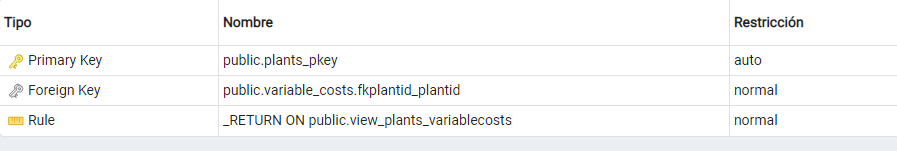

## Lo que sigue, es crear una vista de esta relacion


In [13]:
# creamos la vista
comando = '''select p.plantid, p.plantlocationlatitude, p.plantlocationlongitude, p.plantprodcapacityliters,
                    p.plantrailtransportationcapacityliters, p.plantroadtransportationcapacityliters,
                    v.detergentid, v.costperliter   
             from plants as p
             left join variable_costs v
             on p.plantid = v.plantid'''

comando_vista = '''create view view_plants_variableCosts 
                as {}'''.format(comando)
usuario.ejecutar(comando_vista)

In [18]:
# mirar la vista
comando = 'select * from view_plants_variableCosts'
df = usuario.mostrar_tabla(comando)
df.head()


,0,1,2,3,4,5,6,7
0,Plant001,67.95458019,30.95143418,760,324,362,Det001,20
1,Plant002,18.38170216,-23.86330645,906,76,201,Det001,20
2,Plant003,61.77910668,-29.66737339,691,382,345,Det001,20
3,Plant004,78.66031164,81.44016527,165,294,445,Det001,20
4,Plant005,53.05397278,-95.24078678,1000,292,499,Det001,20


## **3) Establecer la relacion entre las tablas routes_availables, routes_segment y routes_endtoend.**

In [27]:
# Miremos las tablas
## Partamos con la tabla 'routes_available'
comando = 'select * from routes_available'
columnas, df = usuario.mostrar_tabla(comando, 'routes_available')
print(columnas)
df


[('(routeid,"character varying")',), ('(startroute,"character varying")',), ('(middleroute,"character varying")',), ('(endroute,"character varying")',), ('(railuse,integer)',)]


,0,1,2,3,4
0,Route0097,Plant001,DC002,Customer005,0
1,Route0098,Plant001,DC005,Customer005,0
2,Route0099,Plant001,DC002,Customer005,1
3,Route00100,Plant002,DC001,Customer006,1
4,Route00101,Plant002,DC003,Customer006,1
...,...,...,...,...,...
115,Route00116,Plant001,nan,Customer007,0
116,Route00117,Plant002,nan,Customer007,1
117,Route00118,Plant004,DC001,Customer002,0
118,Route00119,Plant001,DC001,Customer003,0


In [22]:
# Notamos que la primera columna podria funcionar como primary key, verifiquemos las condiciones
## 1) no existan datos duplicados en la columna
columna1 = list(df[0][:])
conjunto1 = set(columna1)
if len(columna1) == len(conjunto1):
    print('ok')
else:
    print('corregir valores duplicados')

ok


In [29]:
# 2) la segunda condicion es que esta columna asegure unicidad en los registros
## para este caso, es una combinacion de todas las columnas
col2 = list(df[1][:])
col3 = list(df[2][:])
col4 = list(df[3][:])
col5 = list(df[4][:])
rutas = [col2[i] + '_' + col3[i] + '_' + col4[i] + '_' + str(col5[i]) for i in range(len(columna1))]
print(len(rutas))
conjunto_rutas = set(rutas)
print(len(conjunto_rutas))


120
120


In [30]:
# Bien, ahora que nos aseguramos que la columna1 puede actuar como primary key, resta establecerla
comando = 'alter table routes_available add primary key (routeid)'
usuario.ejecutar(comando)

## Listo, continuemos con la siguiente tabla (routes_segment)

In [3]:
# mirar la tabla
comando = 'select * from routes_segment'
columnas, df = usuario.mostrar_tabla(comando, 'routes_segment')
print(columnas)
df


[('(segmentstart,"character varying")',), ('(segmentend,"character varying")',), ('(segmentmode,"character varying")',), ('(segmentcostperunit,integer)',)]


,0,1,2,3
0,Plant001,DC001,Road,4
1,Plant002,DC002,Rail,4
2,Plant001,DC004,Road,6
3,Plant001,DC004,Rail,3
4,Plant002,DC002,Road,5
...,...,...,...,...
115,Plant002,Customer007,Road,9
116,Plant001,Customer002,Rail,1
117,Plant003,Customer002,Road,9
118,Plant004,Customer002,Rail,7


## Lo que se puede observar es que no existe una columna con la cual identificar valores unicos. Esta es necesaria crearla de forma tal que luego sea factible conectarla con la tabla de 'routes availables'

In [26]:
# Agreguemos una columna nueva a la tabla que sirva como identificador y clave foranea a la vez
col1 = list(df[0][:])
col2 = list(df[1][:])
col3 = list(df[2][:])

columnaID = [col1[i] + '_' + col2[i] + '_' + col3[i] for i in range(len(col1))]

# ahora verifiquemos que esta columna nos puede servir como identificador
conjuntoID = set(columnaID)
if len(columnaID) == len(conjuntoID):
    print('ok')
else:
    print('valores duplicados')
    

valores duplicados


In [28]:
import numpy as np
# En esta ocacion encontramos valores duplicados
#print(len(columnaID))
#print(len(conjuntoID))

## Son 8 los valores duplicados

## pensemos en una manera de identificar y eliminar los valores dupliados
### una manera sencilla para identificar los valores duplicados -> (valores lista - valores conjunto)
duplicados = [valor for valor in columnaID]
for valor in conjuntoID:
    duplicados.remove(valor)
print(len(columnaID))
print(duplicados)
print(len(duplicados))

120
['Plant002_Customer001_Rail', 'Plant001_Customer001_Rail', 'Plant001_Customer001_Rail', 'Plant002_Customer001_Rail', 'Plant001_Customer002_Rail', 'Plant001_Customer002_Rail', 'Plant002_Customer002_Rail', 'Plant001_Customer002_Rail']
8


## Bien con esto tenemos identificado las filas duplicadas, lo que sigue es eliminar estas filas de la tabla

In [6]:
# Ahora estaba pensando que si me dedico a eliminar asi tal cual los valores que aparecen en los duplicados
# podria llegar a eliminar todas las filas que comparten este ID, para que esto no suceda lo primero que voy
# a hacer es agregar una columna nueva que sirva como indice, luego identificare los inidices duplicados
# y por ultimo eliminare las filas que me indiquen estos indices

## añadir el indice a la tabla
comando = 'Alter table routes_segment add column Indice serial'
usuario.ejecutar(comando)

# miremos los cambios
comando = 'select * from routes_segment'
columnas1, df1 = usuario.mostrar_tabla(comando, 'routes_segment')
print(columnas1)
df1


[('(segmentstart,"character varying")',), ('(segmentend,"character varying")',), ('(segmentmode,"character varying")',), ('(segmentcostperunit,integer)',), ('(indice,integer)',)]


,0,1,2,3,4
0,Plant001,DC004,Rail,3,1
1,Plant002,DC002,Road,5,2
2,Plant001,DC005,Rail,8,3
3,Plant001,DC003,Road,5,4
4,Plant002,DC005,Rail,5,5
...,...,...,...,...,...
107,Plant004,Customer002,Rail,7,108
108,Plant001,Customer003,Road,7,109
109,Plant001,DC001,Road,4,110
110,Plant002,DC002,Rail,4,111


In [8]:
# Bien, ahora identifiquemos el valor de los indices de las filas duplicadas
indices = list(df1[4][:])

# un diccionario nos podria ser util
col1 = list(df1[0][:])
col2 = list(df1[1][:])
col3 = list(df1[2][:])

columnaID = [col1[i] + '_' + col2[i] + '_' + col3[i] for i in range(len(col1))]

diccionario = {}
for ind in range(len(indices)):
    diccionario[columnaID[ind]] = indices[ind]
#print(len(diccionario))  ## imprime 112 y no 120
## Ojo que el diccionario ya nos elimino los valores duplicados 

indices_dic = list(diccionario.values())
#print(len(indices_dic)) # imprime 112

# bien, ahora identifiquemos el indice de los valores que vamos a eliminar
ind_duplicados = [valor for valor in indices]
for ind in indices_dic:
    ind_duplicados.remove(ind)
#print(ind_duplicados)  ## imprime [90, 91, 95, 99, 107, 111, 113]



## Listo, ahora estamos en conocimiento de los indices de las filas que debemos eliminar


In [9]:
# para aliminarlas ejecutamos el siguiente comando
for ind in ind_duplicados:
    comando_base = 'delete from routes_segment where indice = {}'.format(ind)
    usuario.ejecutar(comando_base)

# miremos los cambios
comando = 'select * from routes_segment'
columnas2, df2 = usuario.mostrar_tabla(comando, 'routes_segment')
print(columnas2)
df2


[('(segmentstart,"character varying")',), ('(segmentend,"character varying")',), ('(segmentmode,"character varying")',), ('(segmentcostperunit,integer)',), ('(indice,integer)',)]


,0,1,2,3,4
0,Plant001,DC004,Rail,3,1
1,Plant002,DC002,Road,5,2
2,Plant001,DC005,Rail,8,3
3,Plant001,DC003,Road,5,4
4,Plant002,DC005,Rail,5,5
...,...,...,...,...,...
107,Plant004,Customer002,Rail,7,108
108,Plant001,Customer003,Road,7,109
109,Plant001,DC001,Road,4,110
110,Plant002,DC002,Rail,4,111


## Listo, quitamos las filas confilctivas
### Lo que necesitamos hacer ahora, es borrar la columna 'indice' y luego agregar la columna identificadora


In [10]:
# eliminar la columna indice 
comando = 'alter table routes_segment drop column indice'
usuario.ejecutar(comando)

# miremos los cambios
comando = 'select * from routes_segment'
columnas3, df3 = usuario.mostrar_tabla(comando, 'routes_segment')
print(columnas3)
df3


[('(segmentstart,"character varying")',), ('(segmentend,"character varying")',), ('(segmentmode,"character varying")',), ('(segmentcostperunit,integer)',)]


,0,1,2,3
0,Plant001,DC004,Rail,3
1,Plant002,DC002,Road,5
2,Plant001,DC005,Rail,8
3,Plant001,DC003,Road,5
4,Plant002,DC005,Rail,5
...,...,...,...,...
107,Plant004,Customer002,Rail,7
108,Plant001,Customer003,Road,7
109,Plant001,DC001,Road,4
110,Plant002,DC002,Rail,4


In [14]:
# Volvamos a generar nuestra columna identificadora (pero esta vez, ya estamos seguro de que sirvirá)
col1 = list(df3[0][:])
col2 = list(df3[1][:])
col3 = list(df3[2][:])

columna_id_arreglada = [col1[i] + '_' + col2[i] + '_' + col3[i] for i in range(len(col1))]
#print(len(columna_id_arreglada))


# ahora añadiremos la columna corregida a la tabla
usuario.agregar_columna('routes_segment', 'segmentid', columna_id_arreglada)

# miremos los cambios
comando = 'select * from routes_segment'
columnas4, df4 = usuario.mostrar_tabla(comando, 'routes_segment')
print(columnas4)
df4


[('(segmentstart,"character varying")',), ('(segmentend,"character varying")',), ('(segmentmode,"character varying")',), ('(segmentcostperunit,integer)',), ('(segmentid,"character varying")',)]


,0,1,2,3,4
0,Plant001,DC004,Rail,3,Plant001_DC004_Rail
1,Plant002,DC002,Road,5,Plant002_DC002_Road
2,Plant001,DC005,Rail,8,Plant001_DC005_Rail
3,Plant001,DC003,Road,5,Plant001_DC003_Road
4,Plant002,DC005,Rail,5,Plant002_DC005_Rail
...,...,...,...,...,...
107,Plant002,Customer001,Rail,8,Plant002_Customer001_Rail
108,Plant001,Customer004,Road,1,Plant001_Customer004_Road
109,Plant001,Customer006,Road,9,Plant001_Customer006_Road
110,Plant001,Customer002,Rail,1,Plant001_Customer002_Rail


## Continuemos a analizar la tabla routes_endtoend

In [1]:
# conectemos
from raaraya1 import SQL
import pandas as pd
import psycopg2

usuario = SQL('curso_postgresql', 'Tester', '123456')


In [2]:
# Miremos la tabla
comando = 'select * from routes_endtoend'
columnas, df = usuario.mostrar_tabla(comando, 'routes_endtoend')
print(columnas)
df


[('(start,"character varying")',), ('(final,"character varying")',), ('(endtoendcostperliter,integer)',)]


,0,1,2
0,Plant001,Customer001,9
1,Plant002,Customer001,7
2,Plant002,Customer002,9
3,Plant003,Customer002,5
4,Plant004,Customer002,6
5,Plant001,Customer002,7
6,Plant004,Customer003,3
7,Plant001,Customer003,10
8,Plant002,Customer003,7
9,Plant003,Customer003,6


## Para esta tabla, tambien podemos notar que no existe una columna con la cual identificar unicamente los resgistros (filas).
### De forma similar a la tabla anterior, se prosiguirá a la elaboracion de una columna identificadora asegurando un metodo para establecer la coneccion con el resto de las tablas


In [5]:
# genermo la columna identificadora
col1 = list(df[0][:])
col2 = list(df[1][:])

col_id = [col1[i] + '_' + col2[i] for i in range(len(col1))]
#print(col_id)

# averiguemos si esta columna posee o no valores duplicados
conjunto = set(col_id)

if len(conjunto) == len(col_id):
    print('ok')
else:
    duplicados = len(col_id) - len(conjunto)
    print('existen {} valore duplicados'.format(duplicados))


ok


## Listo, ahora que verificamos que esta nueva lista puede funcionar como identificador, proseguimos a añadirla y establecerla como primary key

In [13]:
# añadir columna
usuario.agregar_columna('routes_endtoend', 'end_id', col_id)

# establecer primary key
comando = 'alter table routes_endtoend add primary key (end_id)'
usuario.ejecutar(comando)

# miremos los cambios
comando = 'select * from routes_endtoend'
columnas1, df1 = usuario.mostrar_tabla(comando, 'routes_endtoend')
print(columnas1)
df1



[('(start,"character varying")',), ('(final,"character varying")',), ('(endtoendcostperliter,integer)',), ('(end_id,"character varying")',)]


,0,1,2,3
0,Plant001,Customer001,9,Plant001_Customer001
1,Plant002,Customer001,7,Plant002_Customer001
2,Plant002,Customer002,9,Plant002_Customer002
3,Plant003,Customer002,5,Plant003_Customer002
4,Plant004,Customer002,6,Plant004_Customer002
5,Plant001,Customer002,7,Plant001_Customer002
6,Plant004,Customer003,3,Plant004_Customer003
7,Plant001,Customer003,10,Plant001_Customer003
8,Plant002,Customer003,7,Plant002_Customer003
9,Plant003,Customer003,6,Plant003_Customer003


## Bien, lo que vamos hacer ahora son un par de cosas que se me fueron quedando en el camino
- En la tabla 'routes_available' agregar tres nuevas columnas (segment1, segment2, end_to_end) que serviran de foreign keys
- establecer el primary key de la tabla 'routes_segment'
- establecer las relaciones de dependencias entre tablas


## Agregar columnas nuevas para generar las relaciones

In [14]:
# generar las nuevas columnas para la tabla 'routes_available'

# miremos la tabla
comando = 'select * from routes_available'
columnas, df = usuario.mostrar_tabla(comando, 'routes_available')
print(columnas)
df


[('(routeid,"character varying")',), ('(startroute,"character varying")',), ('(middleroute,"character varying")',), ('(endroute,"character varying")',), ('(railuse,integer)',)]


,0,1,2,3,4
0,Route0097,Plant001,DC002,Customer005,0
1,Route0098,Plant001,DC005,Customer005,0
2,Route0099,Plant001,DC002,Customer005,1
3,Route00100,Plant002,DC001,Customer006,1
4,Route00101,Plant002,DC003,Customer006,1
...,...,...,...,...,...
115,Route00116,Plant001,nan,Customer007,0
116,Route00117,Plant002,nan,Customer007,1
117,Route00118,Plant004,DC001,Customer002,0
118,Route00119,Plant001,DC001,Customer003,0


In [31]:
# para generar la primera columna 'segment1' ocuparemos las columnas 1, 2 y 4
# para generar la segunda columna 'segment2' ocuparemos las columnas 2, 3 y 4
# para generar la tercera columna 'end_to_end' ocuparemos las columnas 1 y 3

col1 =  list(df[1][:])
col2 =  list(df[2][:])
col3 =  list(df[3][:])
col4 =  list(df[4][:])

# segment1
segment1 = []
for i in range(len(col1)):
    # ocupa tren -> 'Rail'
    if col4[i] == 0:
        valor = col1[i] + '_' + col2[i] + '_Rail'
        segment1.append(valor)
    
    # no ocupa tren -> 'Road'
    else:
        valor = col1[i] + '_' + col2[i] + '_Road'
        segment1.append(valor)
    
# segment2
segment2 = []
for i in range(len(col1)):
    # ocupa tren -> 'Rail'
    if col4[i] == 0:
        valor = col2[i] + '_' + col3[i] + '_Rail'
        segment2.append(valor)
    
    # no ocupa tren -> 'Road'
    else:
        valor = col2[i] + '_' + col3[i] + '_Road'
        segment2.append(valor)

# end_to_end
end_to_end = [col1[i] + '_' + col3[i] for i in range(len(col1))]



In [33]:
# agreguemos las columnas a la tabla
# añadir segment1
usuario.agregar_columna('routes_available', 'segment1', segment1)
# añadir segment2
usuario.agregar_columna('routes_available', 'segment2', segment2)
# añadir end_to_end
usuario.agregar_columna('routes_available', 'end_to_end', end_to_end)


# corregir errores
'''comando = 'alter table routes_available drop column segment1'
usuario.ejecutar(comando)
comando = 'alter table routes_available drop column segment2'
usuario.ejecutar(comando)
comando = 'alter table routes_available drop column end_to_end'
usuario.ejecutar(comando)
'''

# miremos los cambios
comando = 'select * from routes_available'
columnas1, df1 = usuario.mostrar_tabla(comando, 'routes_available')
print(columnas1)
df1


[('(routeid,"character varying")',), ('(startroute,"character varying")',), ('(middleroute,"character varying")',), ('(endroute,"character varying")',), ('(railuse,integer)',), ('(segment1,"character varying")',), ('(segment2,"character varying")',), ('(end_to_end,"character varying")',)]


,0,1,2,3,4,5,6,7
0,Route0048,Plant001,DC003,Customer005,0,Plant001_DC001_Road,DC001_Customer006_Road,Plant001_Customer005
1,Route0053,Plant001,DC002,Customer006,0,Plant002_DC004_Road,DC003_Customer001_Rail,Plant002_Customer006
2,Route0071,Plant002,DC005,Customer007,0,Plant001_DC003_Road,DC001_Customer001_Rail,Plant002_Customer006
3,Route0074,Plant001,DC005,Customer007,1,Plant002_DC004_Rail,DC004_Customer001_Road,Plant001_Customer001
4,Route0081,Plant002,DC003,Customer001,1,Plant002_DC002_Rail,DC002_Customer001_Road,Plant001_Customer001
...,...,...,...,...,...,...,...,...
115,Route00111,Plant001,DC003,Customer007,0,Plant002_DC001_Road,DC005_Customer007_Road,Plant002_Customer007
116,Route0064,Plant001,DC001,Customer006,0,Plant001_DC001_Rail,DC001_Customer001_Rail,Plant001_Customer001
117,Route0056,Plant002,DC005,Customer006,1,Plant001_DC003_Road,DC003_Customer007_Road,Plant001_Customer007
118,Route0061,Plant002,DC004,Customer006,1,Plant002_DC004_Rail,DC004_Customer006_Rail,Plant002_Customer006


## Establecer el primary key de la tabla 'routes_segment'

In [34]:
# añadir primary key
comando = 'alter table routes_segment add primary key (segmentid)'
usuario.ejecutar(comando)


## Establecer las relaciones entre tablas

In [36]:
# entre routes_available(segment1) - routes_segment(segmentid)

tabla1 = 'routes_available'
columna1 = 'segment1'
tabla2 = 'routes_segment'
columna2 = 'segmentid'
comando = '''alter table {} 
             add constraint FK{} 
             foreign key({}) 
             references {} ({})'''.format(tabla1, columna1 + '_' + columna2 ,columna1, tabla2, columna2)

usuario.ejecutar(comando)


ForeignKeyViolation: inserción o actualización en la tabla «routes_available» viola la llave foránea «fksegment1_segmentid»
DETAIL:  La llave (segment1)=(Plant002_nan_Road) no está presente en la tabla «routes_segment».


## Este error sucedio porque al crear las columnas adicionales en la tabla 'routes_available' no condicione las rutas directas.
### Para corregir esto, corregire las columnas ante de añadirlas nuevamente.

In [2]:
# mirar la tabla
comando = 'select * from routes_available'
columnas, df = usuario.mostrar_tabla(comando, 'routes_available')
print(columnas)
df


[('(routeid,"character varying")',), ('(startroute,"character varying")',), ('(middleroute,"character varying")',), ('(endroute,"character varying")',), ('(railuse,integer)',), ('(segment1,"character varying")',), ('(segment2,"character varying")',), ('(end_to_end,"character varying")',)]


,0,1,2,3,4,5,6,7
0,Route0048,Plant001,DC003,Customer005,0,Plant001_DC001_Road,DC001_Customer006_Road,Plant001_Customer005
1,Route0053,Plant001,DC002,Customer006,0,Plant002_DC004_Road,DC003_Customer001_Rail,Plant002_Customer006
2,Route0071,Plant002,DC005,Customer007,0,Plant001_DC003_Road,DC001_Customer001_Rail,Plant002_Customer006
3,Route0074,Plant001,DC005,Customer007,1,Plant002_DC004_Rail,DC004_Customer001_Road,Plant001_Customer001
4,Route0081,Plant002,DC003,Customer001,1,Plant002_DC002_Rail,DC002_Customer001_Road,Plant001_Customer001
...,...,...,...,...,...,...,...,...
115,Route00111,Plant001,DC003,Customer007,0,Plant002_DC001_Road,DC005_Customer007_Road,Plant002_Customer007
116,Route0064,Plant001,DC001,Customer006,0,Plant001_DC001_Rail,DC001_Customer001_Rail,Plant001_Customer001
117,Route0056,Plant002,DC005,Customer006,1,Plant001_DC003_Road,DC003_Customer007_Road,Plant001_Customer007
118,Route0061,Plant002,DC004,Customer006,1,Plant002_DC004_Rail,DC004_Customer006_Rail,Plant002_Customer006


In [3]:
# eliminemos las ultimas 3 columnas
comando = 'alter table routes_available drop column segment1'
usuario.ejecutar(comando)
comando = 'alter table routes_available drop column segment2'
usuario.ejecutar(comando)
comando = 'alter table routes_available drop column end_to_end'
usuario.ejecutar(comando)

# mostrar tabla
comando = 'select * from routes_available'
columnas, df = usuario.mostrar_tabla(comando, 'routes_available')
print(columnas)
df


[('(routeid,"character varying")',), ('(startroute,"character varying")',), ('(middleroute,"character varying")',), ('(endroute,"character varying")',), ('(railuse,integer)',)]


,0,1,2,3,4
0,Route0048,Plant001,DC003,Customer005,0
1,Route0053,Plant001,DC002,Customer006,0
2,Route0071,Plant002,DC005,Customer007,0
3,Route0074,Plant001,DC005,Customer007,1
4,Route0081,Plant002,DC003,Customer001,1
...,...,...,...,...,...
115,Route00111,Plant001,DC003,Customer007,0
116,Route0064,Plant001,DC001,Customer006,0
117,Route0056,Plant002,DC005,Customer006,1
118,Route0061,Plant002,DC004,Customer006,1


In [4]:
# volvemos a generar las columnas
col1 =  list(df[1][:])
col2 =  list(df[2][:])
col3 =  list(df[3][:])
col4 =  list(df[4][:])

# segment1
segment1 = []
for i in range(len(col1)):
    # ocupa tren -> 'Rail'
    if col4[i] == 0:
        valor = col1[i] + '_' + col2[i] + '_Rail'
        segment1.append(valor)
    
    # no ocupa tren -> 'Road'
    else:
        valor = col1[i] + '_' + col2[i] + '_Road'
        segment1.append(valor)
    
# segment2
segment2 = []
for i in range(len(col1)):
    # ocupa tren -> 'Rail'
    if col4[i] == 0:
        valor = col2[i] + '_' + col3[i] + '_Rail'
        segment2.append(valor)
    
    # no ocupa tren -> 'Road'
    else:
        valor = col2[i] + '_' + col3[i] + '_Road'
        segment2.append(valor)

# end_to_end
end_to_end = [col1[i] + '_' + col3[i] for i in range(len(col1))]



In [22]:
# ahora toca corregir el error
## este es uno de los valores que toca corregir (la idea es dejarlo como Null)
print(segment1[15])

## una idea de como podria ser la condicion para detectarlo
valor = segment1[15]
if valor[-8:-5] == 'nan':
    valor = ''
print(valor)

# apliquemos esta a las columnas
# segment1
for ind, valor in enumerate(segment1):
    if valor[-8:-5] == 'nan':
        segment1[ind] = ''
        
# segment2 (notar que para este caso estos parten con nan)
for ind, valor in enumerate(segment2):
    if valor[:3] == 'nan':
        segment2[ind] = ''





['DC003_Customer005_Rail', 'DC002_Customer006_Rail', 'DC005_Customer007_Rail', 'DC005_Customer007_Road', 'DC003_Customer001_Road', 'DC001_Customer002_Road', 'DC002_Customer006_Rail', 'DC001_Customer002_Road', 'DC004_Customer002_Road', 'DC002_Customer001_Road', 'DC002_Customer002_Rail', 'DC005_Customer007_Rail', 'DC002_Customer002_Rail', 'DC002_Customer005_Rail', 'DC003_Customer002_Rail', '', 'DC004_Customer007_Rail', 'DC003_Customer006_Road', 'DC001_Customer001_Road', 'DC002_Customer002_Road', 'DC002_Customer002_Road', 'DC003_Customer001_Road', 'DC002_Customer002_Road', 'DC003_Customer006_Rail', 'DC005_Customer007_Road', 'DC005_Customer001_Rail', 'DC005_Customer006_Rail', 'DC002_Customer006_Road', 'DC003_Customer005_Road', 'DC002_Customer007_Rail', 'DC004_Customer002_Rail', 'DC004_Customer007_Road', 'DC001_Customer003_Road', 'DC004_Customer001_Rail', 'DC001_Customer003_Road', 'DC002_Customer006_Road', 'DC005_Customer001_Road', 'DC004_Customer007_Rail', 'DC005_Customer001_Road', 'DC00

In [23]:
# agreguemos las columnas a la tabla
# añadir segment1
usuario.agregar_columna('routes_available', 'segment1', segment1)
# añadir segment2
usuario.agregar_columna('routes_available', 'segment2', segment2)
# añadir end_to_end
usuario.agregar_columna('routes_available', 'end_to_end', end_to_end)


# corregir errores
'''comando = 'alter table routes_available drop column segment1'
usuario.ejecutar(comando)
comando = 'alter table routes_available drop column segment2'
usuario.ejecutar(comando)
comando = 'alter table routes_available drop column end_to_end'
usuario.ejecutar(comando)
'''

# miremos los cambios
comando = 'select * from routes_available'
columnas1, df1 = usuario.mostrar_tabla(comando, 'routes_available')
print(columnas1)
df1


[('(routeid,"character varying")',), ('(startroute,"character varying")',), ('(middleroute,"character varying")',), ('(endroute,"character varying")',), ('(railuse,integer)',), ('(segment1,"character varying")',), ('(segment2,"character varying")',), ('(end_to_end,"character varying")',)]


,0,1,2,3,4,5,6,7
0,Route0060,Plant002,DC002,Customer006,0,Plant002_DC002_Rail,DC005_Customer007_Road,Plant001_Customer006
1,Route0030,Plant002,DC001,Customer002,1,Plant002_DC001_Road,DC003_Customer001_Road,Plant002_Customer007
2,Route0088,Plant002,DC004,Customer002,1,Plant002_DC004_Road,DC001_Customer002_Road,Plant001_Customer007
3,Route0021,Plant004,DC002,Customer002,0,Plant004_DC002_Rail,DC002_Customer006_Rail,Plant002_Customer001
4,Route0028,Plant001,DC003,Customer002,0,Plant001_DC003_Rail,DC002_Customer001_Road,Plant002_Customer006
...,...,...,...,...,...,...,...,...
115,Route0072,Plant001,DC003,Customer007,1,Plant001_DC003_Road,DC001_Customer007_Rail,Plant001_Customer007
116,Route0057,Plant002,DC003,Customer006,0,Plant002_DC003_Rail,DC003_Customer006_Rail,Plant002_Customer006
117,Route0039,Plant003,DC001,Customer003,0,Plant003_DC001_Rail,DC001_Customer003_Rail,Plant003_Customer003
118,Route0011,Plant002,DC001,Customer001,0,Plant002_DC001_Rail,DC001_Customer001_Rail,Plant002_Customer001


In [24]:
# volvamos a intentar establecer las relaciones foraneas
# entre routes_available(segment1) - routes_segment(segmentid)

tabla1 = 'routes_available'
columna1 = 'segment1'
tabla2 = 'routes_segment'
columna2 = 'segmentid'
comando = '''alter table {} 
             add constraint FK{} 
             foreign key({}) 
             references {} ({})'''.format(tabla1, columna1 + '_' + columna2 ,columna1, tabla2, columna2)

usuario.ejecutar(comando)

ForeignKeyViolation: inserción o actualización en la tabla «routes_available» viola la llave foránea «fksegment1_segmentid»
DETAIL:  La llave (segment1)=() no está presente en la tabla «routes_segment».


## JAJA, colocar el valor en blanco NO resulta ser lo mismo que tener un valor NULO.
### Lo que tengo que hacer es eliminar esa parte del registro.

In [2]:
# Como ya tenemos identificado las partes que tenemos que borrar (donde aparece ''), es que debemos 
# ejecutar lo siguiente

# para la columna segment1
comando = "update routes_available set segment1 = NULL where segment1 = ''"
usuario.ejecutar(comando)

# para la columna segment2
comando = "update routes_available set segment2 = NULL where segment2 = ''"
usuario.ejecutar(comando)


In [3]:
# volvamos a intentar establecer las relaciones foraneas
# entre routes_available(segment1) - routes_segment(segmentid)

tabla1 = 'routes_available'
columna1 = 'segment1'
tabla2 = 'routes_segment'
columna2 = 'segmentid'
comando = '''alter table {} 
             add constraint FK{} 
             foreign key({}) 
             references {} ({})'''.format(tabla1, columna1 + '_' + columna2 ,columna1, tabla2, columna2)

usuario.ejecutar(comando)

## Por fin, ya no nos aparecen errores
### Repitamos el proceso para la columna 'segment2' y 'end_to_end'

In [4]:
# entre routes_available(segment2) - routes_segment(segmentid)

tabla1 = 'routes_available'
columna1 = 'segment2'
tabla2 = 'routes_segment'
columna2 = 'segmentid'
comando = '''alter table {} 
             add constraint FK{} 
             foreign key({}) 
             references {} ({})'''.format(tabla1, columna1 + '_' + columna2 ,columna1, tabla2, columna2)

usuario.ejecutar(comando)

In [5]:
# entre routes_available(segment2) - routes_endtoend(end_id)

tabla1 = 'routes_available'
columna1 = 'end_to_end'
tabla2 = 'routes_endtoend'
columna2 = 'end_id'
comando = '''alter table {} 
             add constraint FK{} 
             foreign key({}) 
             references {} ({})'''.format(tabla1, columna1 + '_' + columna2 ,columna1, tabla2, columna2)

usuario.ejecutar(comando)

## Listo, ahora solo hace falta generar la vista.

In [6]:
# creamos la vista
comando = '''select ra.routeid, ra.segment1, rs1.segmentcostperunit, 
                    ra.segment2, rs2.segmentcostperunit, 
                    ra.end_to_end, re.endtoendcostperliter
from routes_available ra, routes_segment rs1, routes_segment rs2, routes_endtoend re
where ra.segment1 = rs1.segmentid and ra.segment2 = rs2.segmentid and ra.end_to_end = re.end_id
'''
comando_vista = '''create view view_cost_routes 
                as {}'''.format(comando)
usuario.ejecutar(comando_vista)

# miremos la vista
comando = 'select * from view_cost_routes'
columnas, df = usuario.mostrar_tabla(comando, 'view_cost_routes')
print(columnas)
df

DuplicateColumn: la columna «segmentcostperunit» fue especificada más de una vez


## Se me olvida que en las vistas no se pueden tener dos columnas con el mismo nombre, lo que voy a hacer entonces es cambiar el nombre de la columna


In [7]:
# creamos la vista
comando = '''select ra.routeid, ra.segment1, rs1.segmentcostperunit as costo_segmento1, ra.segment2, rs2.segmentcostperunit as costo_segmento2, ra.end_to_end, re.endtoendcostperliter
from routes_available ra, routes_segment rs1, routes_segment rs2, routes_endtoend re
where ra.segment1 = rs1.segmentid and ra.segment2 = rs2.segmentid and ra.end_to_end = re.end_id'''

comando_vista = '''create view view_cost_routes 
                as {}'''.format(comando)
usuario.ejecutar(comando_vista)

# miremos la vista
comando = 'select * from view_cost_routes'
columnas, df = usuario.mostrar_tabla(comando, 'view_cost_routes')
print(columnas)
df

[('(routeid,"character varying")',), ('(segment1,"character varying")',), ('(costo_segmento1,integer)',), ('(segment2,"character varying")',), ('(costo_segmento2,integer)',), ('(end_to_end,"character varying")',), ('(endtoendcostperliter,integer)',)]


,0,1,2,3,4,5,6
0,Route0060,Plant002_DC002_Rail,4,DC005_Customer007_Road,1,Plant001_Customer006,10
1,Route0030,Plant002_DC001_Road,9,DC003_Customer001_Road,3,Plant002_Customer007,2
2,Route0088,Plant002_DC004_Road,2,DC001_Customer002_Road,9,Plant001_Customer007,8
3,Route0021,Plant004_DC002_Rail,6,DC002_Customer006_Rail,6,Plant002_Customer001,7
4,Route0028,Plant001_DC003_Rail,4,DC002_Customer001_Road,9,Plant002_Customer006,9
...,...,...,...,...,...,...,...
101,Route0072,Plant001_DC003_Road,5,DC001_Customer007_Rail,8,Plant001_Customer007,8
102,Route0057,Plant002_DC003_Rail,10,DC003_Customer006_Rail,10,Plant002_Customer006,9
103,Route0039,Plant003_DC001_Rail,8,DC001_Customer003_Rail,10,Plant003_Customer003,6
104,Route0011,Plant002_DC001_Rail,5,DC001_Customer001_Rail,10,Plant002_Customer001,7


## Notas adicionales (Errores)

**1) Error al importar el modulo de matplotlib**

Para solucionarlo, conecte un entorno virtual con las bibliotecas necesarias ejecutando los siguiente comando en la terminal 'pip3 install ipykernel', luego 'python -m ipykernel install --name=base'.

Ya por ultimo se tiene que cambiar el kernel.
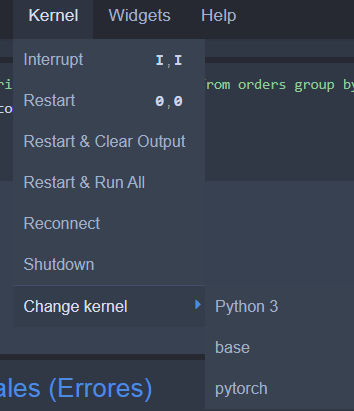
